In [12]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
from matplotlib.colors import LinearSegmentedColormap
import  matplotlib.colors

orb = 16 #number of bands/orbitals

In [4]:
#Importing Wannier90 Hamiltonian

path = "C:/Users/amnedic/Documents/GitHub/RPA_SrCo2As2/Wannier90/SrCo2As2/"
latHam_data = np.genfromtxt(path+'ham_wannier90_hr-SrCo2As2.dat')
L = len(latHam_data)
print('The Wannier functions are defined on', L, 'points in space+orbitals.')

#components of the position vectors in terms of the lattice vectors
list_r = []
#band indices n and m
list_nm = []
#hopping parameter in real space t2
list_re_im = []
for i in range(0, L):
    list_r.append([latHam_data[[i]][0][0], latHam_data[[i]][0][1], latHam_data[[i]][0][2]])
    list_nm.append([int(latHam_data[[i]][0][3]), int(latHam_data[[i]][0][4])])
    list_re_im.append(latHam_data[[i]][0][5] + 1j*latHam_data[[i]][0][6])
    
weights_data = np.genfromtxt(path+'nrpts_wannier90_hr-SrCo2As2.dat', delimiter='\n', dtype=str) #importing weights from Wannier90 output
weights_data_str = [str(t).split() for t in weights_data] 
c_weights_list = [1/int(item) for sublist in weights_data_str for item in sublist]  #c_weights_list is a flat list containing 1/weights
w = len(c_weights_list)

The Wannier functions are defined on 1116416 points in space+orbitals.


In [5]:
#Energy eigenvalues and eigenvectors

def energy(k_biglist):
    eiglist = []
    eigvectors = []
    Ham = np.zeros([16, 16, len(k_biglist)], dtype=complex);
        
    for i in range(w):
        c_exp = np.exp(1j*(np.multiply(k_biglist, list_r[256*i]).sum(1))) #exponent with dot product x*kx + y*ky + z*kz which we will use for FT
        for o in range(256):
            row = 256*i+o
            n = list_nm[row][0]-1;
            m = list_nm[row][1]-1;
            #calculating Hamiltonian in momentum space
            Ham[n][m] += c_weights_list[i]*list_re_im[row]*c_exp;

    #diagonalizing Hamiltonian for each k-value from our list separately                    
    for p in range(len(k_biglist)):
        eig, eigv = la.eigh(Ham[:,:,p])
        eiglist.append(np.real(eig))
        eigvectors.append(eigv)
        
    return (eiglist, eigvectors)

In [6]:
#Fermi surface - k-points sampling

N=200 #k-space discretization NxN
#kz=0 (shows \Gamma, X, Y), kz=0.5 (shows P), kz=1 (shows M)
kz=0.
k_val1 = np.arange(start=0, stop=N+1, step=1)/N
klist_2D1 = [] #k-list in primitive coordinates
kxyz_list=[] #k-list in conventional coordinates
for t2 in range(N+1):
    for t1 in range(N+1):
        knum=[-1+ k_val1[t1]+k_val1[t2], -k_val1[t1]+k_val1[t2], kz] #conventional coordinate
        kxyz_list.append(knum)
        kprim = [np.pi*(knum[1]+knum[2]-knum[0]), np.pi*(knum[0]+knum[2]-knum[1]), np.pi*(knum[0]+knum[1]-knum[2])] #primitive coordinate
        klist_2D1.append(kprim)

In [7]:
#Fermi surface for a given value of electron filling x

start_time = time.time();
energylist = energy(klist_2D1)
ener = energylist[0]
print(round((time.time()-start_time)/60, 3), 'minutes for calculation.');

ener_mu = []
#mu=6.269 #x=0
#xs=0

#mu=6.269-0.075 #x=-0.2
#xs=0.2

mu=6.269-0.129 #x=-0.3
xs=-0.3

for E in ener:
    E = E-mu
    ener_mu.append(E)

3.448 minutes for calculation.


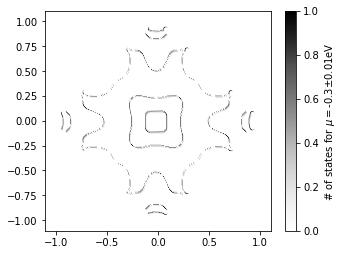

In [8]:
#Fermi surface - plotting

x=[]
y=[]
z=[]
window=0.005 #specified energy-window
for i in range(N+1):
    for j in range(1,N+2):
        it = (N+1)*i+j-1
        en = ener_mu[it]
        enum = 0
        for l in range(orb):
            if en[l]<window and en[l]>-window:
                enum += 1
        x.append(kxyz_list[it][0])
        y.append(kxyz_list[it][1])
        z.append(enum)
        
width = 1.5*3.375
height = 0.8*width
fig = plt.figure(1, figsize = [width,height])
ax = fig.add_subplot(111)
FS=ax.scatter(x, y, c=z, cmap='Greys', s=10)
fig.colorbar(FS, label='# of states for $\mu=$'+str(xs)+'$\pm$'+str(window)+'eV')
#fig.savefig('FS_x='+str(xs)+'_kz='+str(kz)+'_window='+str(window)+'eV.png', dpi=200)
plt.show()

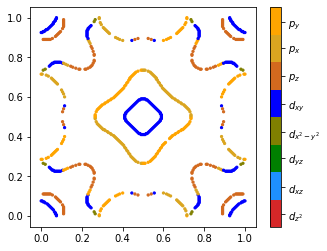

In [33]:
#Orbitally-resolved Fermi surface (all d+p orbitals)

ener_v = energylist[1]
x=[]
y=[]
z=[]
for i in range(N+1):
    for j in range(1,N+2):
        it = (N+1)*i+j-1
        en = ener_mu[it]
        #eigenvectors
        vec_all = np.transpose(ener_v[it])
        vec_abs = np.absolute(vec_all)
    
        for l in range(orb):
            arg = np.argmax(vec_abs[l]) #for orbital content
            if en[l]<window and en[l]>-window:
                if arg==0 or arg==5:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(1)
                elif arg==1 or arg==6:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(2)
                elif arg==2 or arg==7:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(3)
                elif arg==3 or arg==8:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(4)
                elif arg==4 or arg==9:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(5)
                elif arg==10 or arg==13:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(6)
                elif arg==11 or arg==14:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(7)
                elif arg==12 or arg==15:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(8)

fig = plt.figure(1, figsize = [width,height])
ax = fig.add_subplot(111)
cmap8 = matplotlib.colors.ListedColormap(['tab:red', 'dodgerblue', 'green', 'olive', 'blue', 'chocolate', 'goldenrod', 'orange'])
FS=ax.scatter(x, y, c=z, cmap=cmap8, s=5, vmin=1, vmax=8)
cbar = fig.colorbar(FS, ticks=[1.4,2.25,3.2,4,4.9,5.8,6.7,7.5])
cbar.ax.set_yticklabels(['$d_{z^2}$','$d_{xz}$','$d_{yz}$','$d_{x^2-y^2}$','$d_{xy}$','$p_{z}$','$p_{x}$','$p_{y}$'])  # vertically oriented colorbar
#fig.savefig('FS_all_x='+str(xs)+'_kz='+str(kz)+'_window='+str(window)+'eV.png', dpi=200)
plt.show()

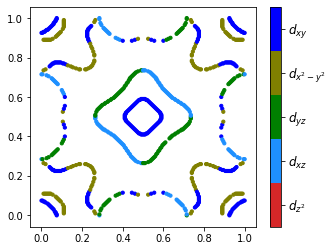

In [39]:
#Orbitally-resolved Fermi surface (d orbitals only)

ener_v = energylist[1]

x=[]
y=[]
z=[]
for i in range(N+1):
    for j in range(1,N+2):
        it = (N+1)*i+j-1
        en = ener_mu[it]
        #eigenvectors
        vec_all = np.transpose(ener_v[it])
        vec_abs = np.absolute(vec_all)
    
        for l in range(orb):
            arg = np.argmax(vec_abs[l][0:10]) #for orbital content
            if en[l]<window and en[l]>-window:
                #print(arg, en[l])
                if arg==0 or arg==5:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(1)
                elif arg==1 or arg==6:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(2)
                elif arg==2 or arg==7:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(3)
                elif arg==3 or arg==8:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(4)
                elif arg==4 or arg==9:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(5)

fig = plt.figure(1, figsize = [width,height])
ax = fig.add_subplot(111)
cmap5 = matplotlib.colors.ListedColormap(['tab:red', 'dodgerblue', 'green', 'olive', 'blue'])
FS=ax.scatter(x, y, c=z, cmap=cmap5, s=10, vmin=1, vmax=5)
cbar = fig.colorbar(FS, ticks=[1.4,2.2,3,3.8,4.6])
cbar.ax.set_yticklabels(['$d_{z^2}$','$d_{xz}$','$d_{yz}$','$d_{x^2-y^2}$','$d_{xy}$','$p_{z}$','$p_{x}$','$p_{y}$'], fontsize='12')  # vertically oriented colorbar
#fig.savefig('FS_d_x='+str(xs)+'_kz='+str(kz)+'_window='+str(window)+'eV.png', dpi=200)
plt.show()